# Import modules

In [1]:
import torch
import torch.optim as optim
from pathlib import Path
import logging
from omegaconf import OmegaConf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import seaborn as sns
from models.config_classes import Config
from models.autoencoder import KoopmanAutoencoder

from models.dataloader import create_dataloaders
from models.metrics import Metric
from models.utils import load_checkpoint, load_datasets

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)

# Set plotting style
plt.style.use("seaborn-v0_8-whitegrid")

cmap = sns.color_palette("icefire", as_cmap=True)

# Configuration


In [2]:
CONFIG_PATH = Path("./configs/model/128_inc.yaml")  # Update this path
CKPT_PATH = Path("./model_outputs/128_inc_kl_1.0/dummy-jc5cf62n/checkpoints/latest_model.pth")

INITIAL_SAMPLE_INDEX = 100
ROLL_OUT_STEPS = 100
FRAME_STRIDE = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
base_config = OmegaConf.structured(Config)
file_config = OmegaConf.load(CONFIG_PATH)

cfg = OmegaConf.merge(base_config, file_config)
OmegaConf.resolve(cfg)
# cfg['training']['use_checkpoint'] = False  # Don't checkpoint during testing

train_dataset, val_dataset, test_dataset = load_datasets(cfg)
train_loader, val_loader, test_loader = create_dataloaders(
            train_dataset, val_dataset, test_dataset, cfg.training
        )

2025-06-13 10:44:57,200 [INFO] Obstacle mask found and processed from static variables.
2025-06-13 10:44:57,204 [INFO] SingleSimOverfit: Using sim 0. Samples: 249
2025-06-13 10:44:57,206 [INFO] Fitted MeanStdNormalizer.
2025-06-13 10:44:57,302 [INFO] Obstacle mask found and processed from static variables.
2025-06-13 10:44:57,305 [INFO] SingleSimOverfit: Using sim 0. Samples: 249
2025-06-13 10:44:57,307 [INFO] Fitted MeanStdNormalizer.
2025-06-13 10:44:57,694 [INFO] Obstacle mask found and processed from static variables.
2025-06-13 10:44:57,708 [INFO] SingleSimOverfit: Using sim 0. Samples: 1288
2025-06-13 10:44:57,725 [INFO] Fitted MeanStdNormalizer.
2025-06-13 10:44:57,783 [INFO] Successfully loaded datasets with type 'SingleSimOverfit'.


#  Load Model 


In [4]:
model = KoopmanAutoencoder(
            data_variables=cfg.data.variables,
            input_frames=cfg.data.input_sequence_length,
            height=cfg.model.height,
            width=cfg.model.width,
            latent_dim=cfg.model.latent_dim,
            hidden_dims=cfg.model.hidden_dims,
            transformer_config=cfg.model.transformer,
            use_checkpoint=cfg.training.use_checkpoint,
            predict_re=cfg.model.predict_re,
            re_grad_enabled=cfg.model.re_grad_enabled,
            **cfg.model.conv_kwargs,
        ).to(DEVICE)
model_params = model.parameters()
optimizer = optim.Adam(model_params, lr=cfg.lr_scheduler.lr)
if CKPT_PATH is not None:
    print(f"Loading from checkpoint: {CKPT_PATH}")
    model, _, _, _ = load_checkpoint(CKPT_PATH, model=model, optimizer=optimizer)

model.eval()

Loading from checkpoint: model_outputs/128_inc_kl_1.0/dummy-jc5cf62n/checkpoints/latest_model.pth


2025-06-13 10:44:58,951 [INFO] Checkpoint loaded from model_outputs/128_inc_kl_1.0/dummy-jc5cf62n/checkpoints/latest_model.pth. Resuming from epoch 161.


KoopmanAutoencoder(
  (history_encoder): HistoryEncoder(
    (linear): Linear(in_features=8192, out_features=1024, bias=True)
    (layers): Sequential(
      (0): ConvBlock(
        (stack): ModuleList(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (3): ReLU()
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ConvBlock(
        (stack): ModuleList(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (1): ReLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (3): ReLU()
        )
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): ConvBlock(
        (s

#  Run Rollout


In [5]:
def run_long_rollout(model, input_seq, rollout_steps):
    input_seq = input_seq.unsqueeze(0).to(DEVICE)  # [1, T, C, H, W]

    with torch.no_grad():
        out = model(input_seq, seq_length=rollout_steps)

    return out  # [T+rollout_steps, C, H, W]

#  Visualize


In [6]:
input_seq, ground_truth, metadata = train_dataset[INITIAL_SAMPLE_INDEX, ROLL_OUT_STEPS]
input_seq["obstacle_mask"] = metadata["obstacle_mask"][0].repeat(*input_seq.batch_size, 1, 1)
print(input_seq)
total_predicted_seq = run_long_rollout(model, input_seq, ROLL_OUT_STEPS)
predicted_seq = total_predicted_seq.x_preds.cpu()
print(total_predicted_seq)

/home/rg625/anaconda3/envs/samudra/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TensorDict(
    fields={
        obstacle_mask: Tensor(shape=torch.Size([2, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        p: Tensor(shape=torch.Size([2, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_x: Tensor(shape=torch.Size([2, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([2, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([2]),
    device=None,
    is_shared=False)
KoopmanOutput(x_recon=TensorDict(
    fields={
        p: Tensor(shape=torch.Size([1, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        v_x: Tensor(shape=torch.Size([1, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        v_y: Tensor(shape=torch.Size([1, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True)},
    batch_size=torch.Size([1]),
    device=None,
    is_shared=False), x_preds=TensorDict(
    fields={
        p: Tensor(s

#  Plot Results 


In [7]:
	
def compute_vorticity(vx, vy):
    vxDx, vxDy = torch.gradient(vx, dim=(1, 2))  # vx: [T, H, W]
    vyDx, vyDy = torch.gradient(vy, dim=(1, 2))
    return vyDx - vxDy  # [T, H, W]

def plot_rollout(gt_dict, pred_dict, variable_name, frame_stride=5):
    """
    Plots the rollout comparison between ground truth and predicted sequence for a given variable.

    Args:
        gt_dict (TensorDict): TensorDict of ground truth tensors [T, H, W] per variable.
        pred_dict (TensorDict): TensorDict of predicted tensors [T, H, W] per variable.
        variable_name (str): The key for the variable to visualize.
        frame_stride (int): Step between frames to plot.
    """
    # Remove batch dimension if present
    if gt_dict.batch_dims == 1 and gt_dict.batch_size[0] == 1:
        gt_dict = gt_dict.squeeze(0)
    if pred_dict.batch_dims == 1 and pred_dict.batch_size[0] == 1:
        pred_dict = pred_dict.squeeze(0)

    gt = gt_dict[variable_name]  # shape: [T, H, W]
    pred = pred_dict[variable_name]  # shape: [T, H, W]

    print(f"Max {variable_name} (GT): {gt.max()}")
    print(f"Max {variable_name} (Pred): {pred.max()}" )
    print(f"Min {variable_name} (GT): {gt.min()}" )
    print(f"Min {variable_name} (Pred): {pred.min()}" )
    print(f"Mean {variable_name} (GT): {gt.mean()}" )
    print(f"Mean {variable_name} (Pred): {pred.mean()}" )
    print(f"Std {variable_name} (GT): {gt.std()}" )
    print(f"std {variable_name} (Pred): {pred.std()}" )

    num_frames = min(gt.shape[0], pred.shape[0])
    indices = list(range(0, num_frames, frame_stride))
    num_plots = min(len(indices), 15)

    fig = plt.figure(figsize=(1.8 * num_plots, 6))
    spec = gridspec.GridSpec(3, num_plots + 1, width_ratios=[1] * num_plots + [0.05])

    for i, idx in enumerate(indices[:num_plots]):
        # Ground truth
        ax_gt = fig.add_subplot(spec[0, i])
        im_gt = ax_gt.imshow(gt[idx].cpu(), cmap=cmap)
        ax_gt.set_title(f"t={idx}")
        ax_gt.axis('off')
        plt.colorbar(im_gt, ax=ax_gt, fraction=0.046, pad=0.04)
        # Prediction
        ax_pred = fig.add_subplot(spec[1, i])
        im_pred = ax_pred.imshow(pred[idx].cpu(), cmap=cmap)
        ax_pred.axis('off')
        plt.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)

        err = gt[idx] - pred[idx]
        ax_err = fig.add_subplot(spec[2, i])
        im_err = ax_err.imshow(err.cpu(), cmap=cmap)
        ax_err.axis('off')
        plt.colorbar(im_err, ax=ax_err, fraction=0.046, pad=0.04)
    # Add shared colorbar
    # cbar_ax = fig.add_subplot(spec[:, -1])
    # fig.colorbar(im_pred, cax=cbar_ax)

    fig.suptitle(f"Koopman AE Rollout for Variable: {variable_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.4, 0.98, 0.95])
    plt.show()


Long Rollout SSIM Metric: 0.2246


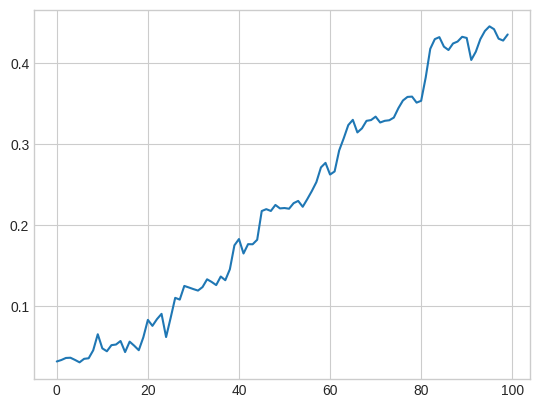

In [8]:
metric = Metric(
    mode=cfg.metric.mode,
    variable_mode=cfg.metric.variable_mode
)
target_denorm = test_loader.denormalize(ground_truth.unsqueeze(0))
preds_denorm = test_loader.denormalize(predicted_seq)

metric_val = metric(
    test_loader.to_unit_range(target_denorm),
    test_loader.to_unit_range(preds_denorm),
)
print(f"\nLong Rollout {cfg.metric.mode} Metric: {metric_val.mean().item():.4f}")
plt.plot(metric_val.squeeze().cpu().detach().numpy())
plt.show()

TensorDict(
    fields={
        p: Tensor(shape=torch.Size([100, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_x: Tensor(shape=torch.Size([100, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([100, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([100]),
    device=None,
    is_shared=False)
TensorDict(
    fields={
        p: Tensor(shape=torch.Size([1, 100, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_x: Tensor(shape=torch.Size([1, 100, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([1, 100, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([1, 100]),
    device=cpu,
    is_shared=False)
Max p (GT): 2.2054457664489746
Max p (Pred): 7.117681503295898
Min p (GT): -2.620847702026367
Min p (Pred): -15.875656127929688
Mean p (GT): 0.06614567339420319
Mean p

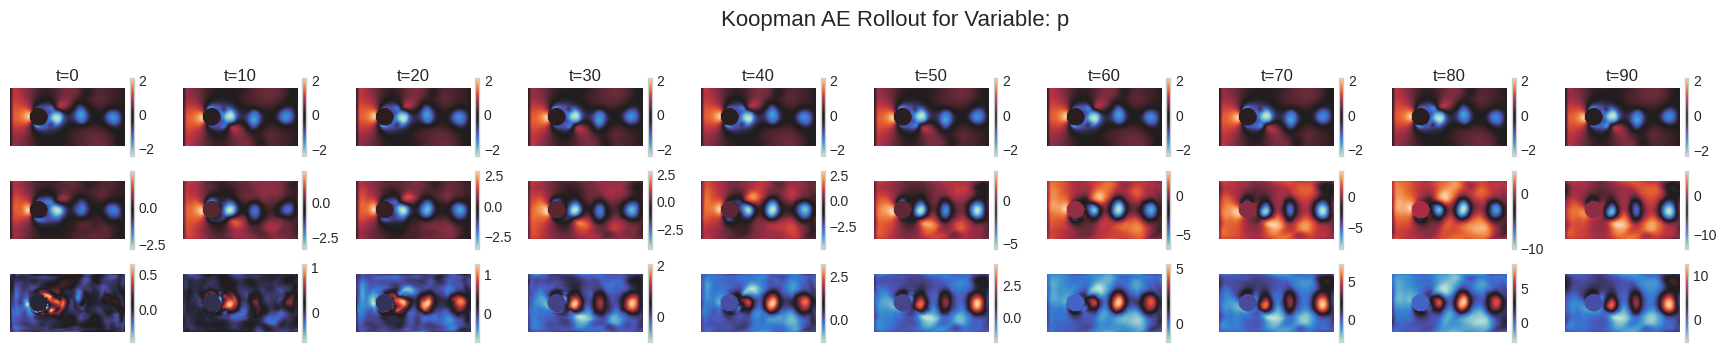

Max v_x (GT): 2.3519201278686523
Max v_x (Pred): 18.873109817504883
Min v_x (GT): -4.000922203063965
Min v_x (Pred): -16.133493423461914
Mean v_x (GT): 0.07611410319805145
Mean v_x (Pred): 0.2585814893245697
Std v_x (GT): 0.9321765899658203
std v_x (Pred): 2.6918933391571045


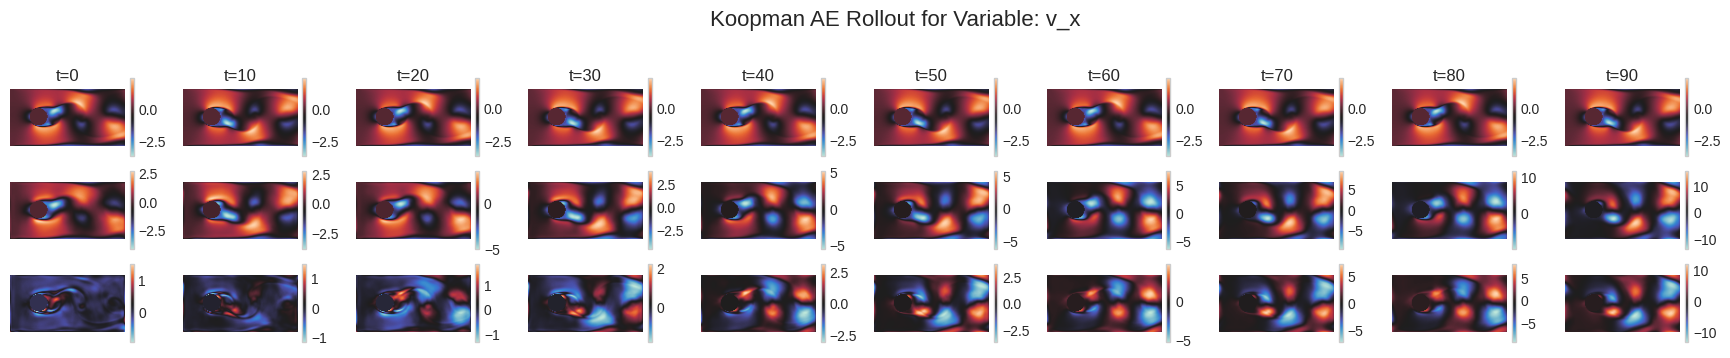

Max v_y (GT): 3.7310738563537598
Max v_y (Pred): 23.047924041748047
Min v_y (GT): -3.7243409156799316
Min v_y (Pred): -22.467187881469727
Mean v_y (GT): 0.0021872487850487232
Mean v_y (Pred): -0.059350527822971344
Std v_y (GT): 1.0449652671813965
std v_y (Pred): 3.712590456008911


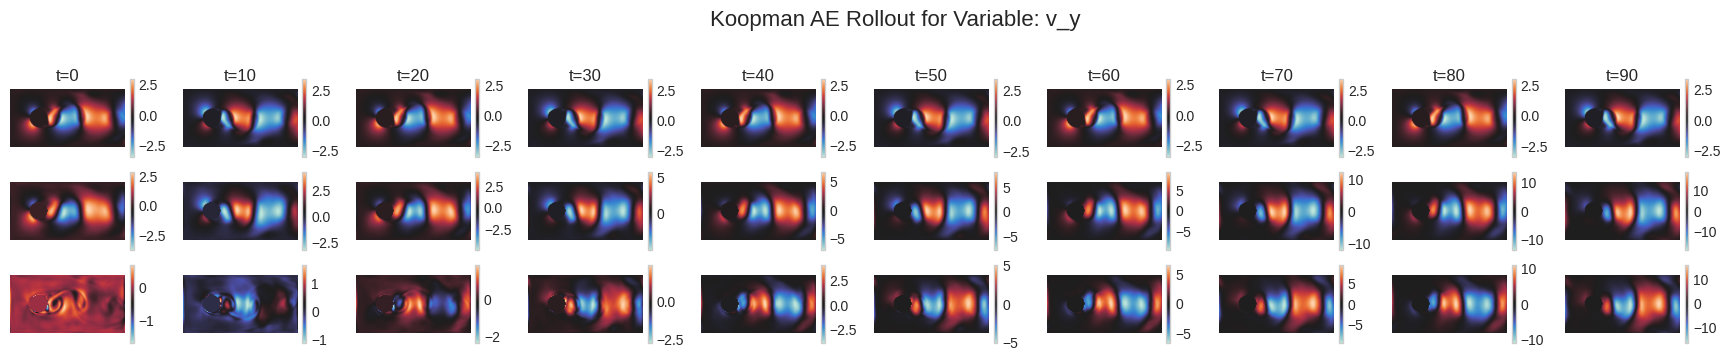

Max vort (GT): 2.524664878845215
Max vort (Pred): 7.003599643707275
Min vort (GT): -1.3798413276672363
Min vort (Pred): -4.937327861785889
Mean vort (GT): 9.414443775312975e-05
Mean vort (Pred): -0.0010425103828310966
Std vort (GT): 0.2062850147485733
std vort (Pred): 0.5571239590644836


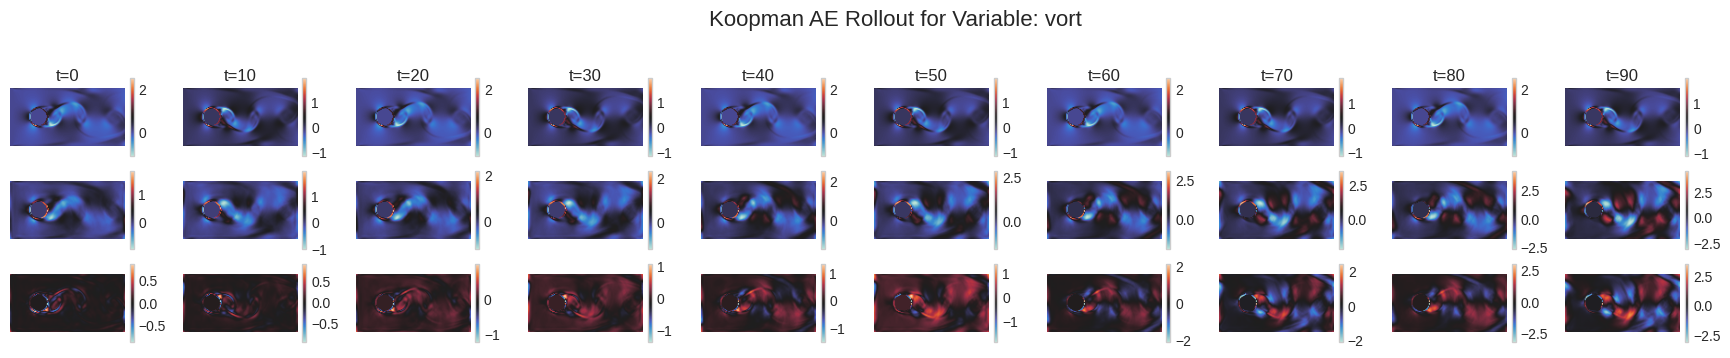

In [9]:
# print(f'true Re: {metadata["Re"]}')
# print(f'pred Re: {total_predicted_seq.reynolds.squeeze().cpu()}')
# plt.plot(total_predicted_seq.reynolds.squeeze().cpu())
# plt.show()
print(ground_truth)
print(predicted_seq)
plot_rollout(ground_truth.cpu(), predicted_seq.squeeze().cpu(), variable_name="p", frame_stride=FRAME_STRIDE)
plot_rollout(ground_truth.cpu(), predicted_seq.squeeze().cpu(), variable_name="v_x", frame_stride=FRAME_STRIDE)
plot_rollout(ground_truth.cpu(), predicted_seq.squeeze().cpu(), variable_name="v_y", frame_stride=FRAME_STRIDE)

# Compute vorticity from vx and vy
vort_gt = compute_vorticity(ground_truth["v_x"], ground_truth["v_y"])
vort_pred = compute_vorticity(predicted_seq["v_x"].squeeze(), predicted_seq["v_y"].squeeze())

# Add derived vorticity to the TensorDicts
ground_truth["vort"] = vort_gt
predicted_seq["vort"] = vort_pred.unsqueeze(0)

# Plot vorticity
plot_rollout(ground_truth.squeeze().cpu(), predicted_seq.squeeze().cpu(), variable_name="vort", frame_stride=FRAME_STRIDE)

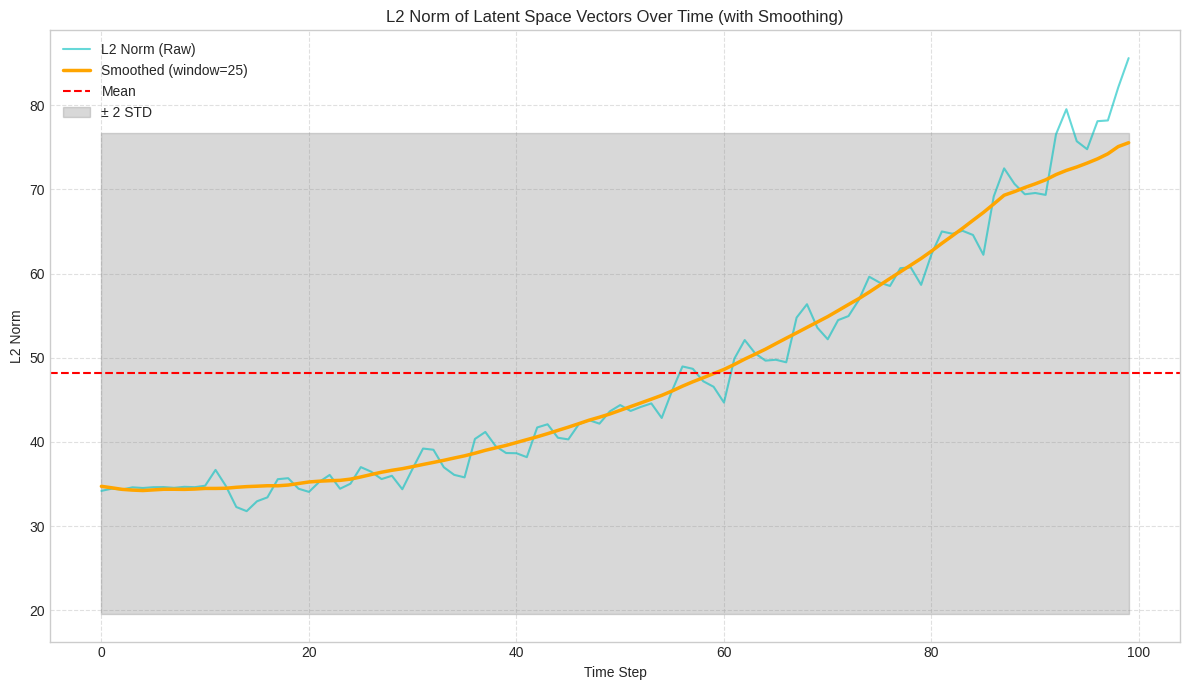

In [ ]:
import matplotlib.pyplot as plt
import torch
import pandas as pd # Import pandas for smoothing

# --- 1. Create Sample Data (replace with your actual data) ---
# This makes the example runnable. You already have z_preds.
z_preds = total_predicted_seq.z_preds.cpu().detach()
# --- End of Sample Data ---


# --- 2. Your Existing Calculations ---
if z_preds.ndim > 2:
    z_preds = z_preds.squeeze()

z_preds_cpu = z_preds.cpu().detach()
latent_norms = torch.norm(z_preds_cpu, dim=-1)
latent_mean = latent_norms.mean()
latent_std = latent_norms.std()


# --- 3. NEW: Smooth the norms using a rolling average ---
# You can adjust this value for more or less smoothing.
# A larger window will result in a smoother line.
window_size = 25

# Convert to a pandas Series to use the rolling() method
latent_norms_series = pd.Series(latent_norms.numpy())

# Calculate the rolling mean. `center=True` prevents the smoothed line from lagging.
# `min_periods=1` handles the edges of the data gracefully.
smoothed_norms = latent_norms_series.rolling(
    window=window_size,
    center=True,
    min_periods=1
).mean()


# --- 4. Plotting ---
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the original data with some transparency
time_steps = range(len(latent_norms))
ax.plot(
    time_steps,
    latent_norms.numpy(),
    label='L2 Norm (Raw)',
    color='c',
    linewidth=1.5,
    alpha=0.6
)

# Plot the NEW smoothed data
ax.plot(
    time_steps,
    smoothed_norms,
    label=f'Smoothed (window={window_size})',
    color='orange',
    linewidth=2.5
)


# Plot the mean and std deviation region from before
ax.axhline(latent_mean.item(), color='r', linestyle='--', label='Mean')
upper_bound = latent_mean + 2 * latent_std
lower_bound = latent_mean - 2 * latent_std
ax.fill_between(
    time_steps,
    lower_bound.item(),
    upper_bound.item(),
    color='gray',
    alpha=0.3,
    label='± 2 STD'
)

# --- 5. Configure and Show the Plot ---
ax.set_title("L2 Norm of Latent Space Vectors Over Time (with Smoothing)")
ax.set_xlabel("Time Step")
ax.set_ylabel("L2 Norm")
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend() # Add a legend to identify all lines

plt.tight_layout()
plt.show()

In [11]:
K_residual_matrix = model.koopman_operator.koopman_linear.weight.T.detach().cpu().numpy()

# logger.info(f"Matrix shape: {K_residual_matrix.shape}")

# # Visualize the matrix as a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(K_residual_matrix, cmap="icefire", center=0)
# plt.title("Heatmap of the Learned Residual Koopman Operator (K_res)", fontsize=16)
# plt.xlabel("Latent Dimension", fontsize=12)
# plt.ylabel("Latent Dimension", fontsize=12)
# plt.show()

2025-06-13 10:45:14,193 [INFO] Computed 1024 eigenvalues.


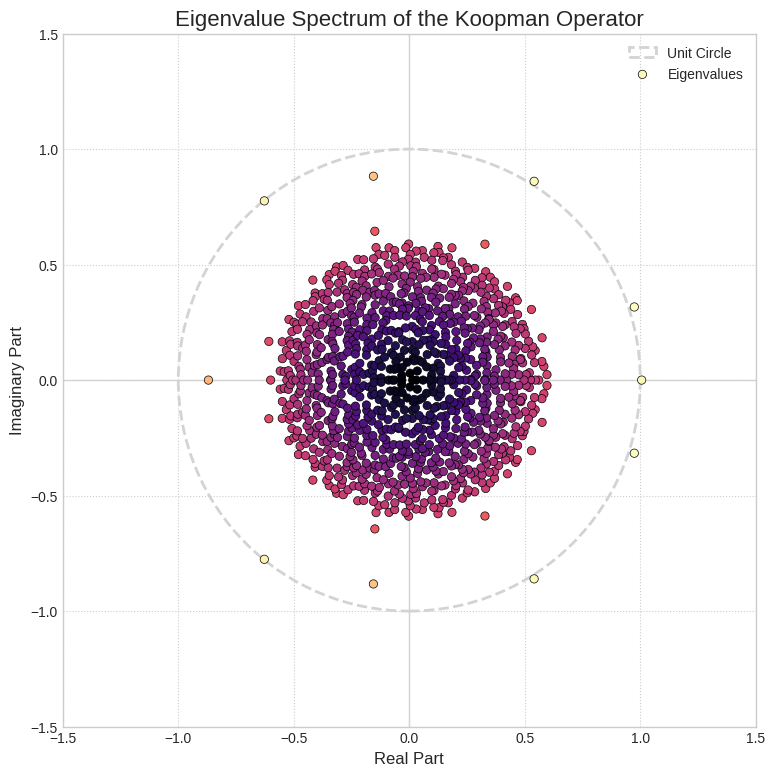

In [12]:
# Create the full Koopman matrix K = I + K_res
latent_dim = model.latent_dim
identity_matrix = np.identity(latent_dim)
K_full_matrix = K_residual_matrix # +identity_matrix 

# Compute the eigenvalues
eigenvalues = np.linalg.eigvals(K_full_matrix)

logger.info(f"Computed {len(eigenvalues)} eigenvalues.")

# --- Visualize the Eigenvalue Spectrum ---
plt.figure(figsize=(9, 9))
ax = plt.gca()

# Plot the unit circle for reference (the stability boundary)
unit_circle = plt.Circle((0, 0), 1, color='lightgray', fill=False, linestyle='--', linewidth=2, label='Unit Circle')
ax.add_patch(unit_circle)

# Plot the eigenvalues
plt.scatter(
    eigenvalues.real,
    eigenvalues.imag,
    c=np.abs(eigenvalues),
    cmap="magma",
    marker="o",
    edgecolor="k",
    linewidth=0.5,
    zorder=3, # Plot eigenvalues on top of the circle
    label="Eigenvalues"
)

# Formatting
ax.axvline(0, color='lightgray', linestyle='-', lw=1)
ax.axhline(0, color='lightgray', linestyle='-', lw=1)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.title("Eigenvalue Spectrum of the Koopman Operator", fontsize=16)
plt.xlabel("Real Part", fontsize=12)
plt.ylabel("Imaginary Part", fontsize=12)
plt.legend()
# plt.colorbar(label="Eigenvalue Magnitude |λ|")
plt.grid(True, linestyle=':')
plt.show()